# The dojo

## Setup training device

In [1]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [2]:
import torch
from torch import device, nn
import torchvision
import torchvision.io as io

torch.manual_seed(42)

print(f'PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}')

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using device: {device}')

ok = io.read_image("data/E45Vejle_1011.jpg")

PyTorch version: 1.13.1
torchvision version: 0.14.1a0+b69fce3
Using device: cpu


## Data loading

### Test dataset

In [3]:
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

MNIST_train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None,
)

MNIST_test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

BATCH_SIZE = 32

MNIST_class_names = MNIST_train_data.classes

MNIST_train_dataloader = DataLoader(MNIST_train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              drop_last=True) # Drop last

MNIST_test_dataloader = DataLoader(MNIST_test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

print(f'Len of train dataloader: {len(MNIST_train_dataloader)} batches of {BATCH_SIZE}')
print(f'Len of test dataloader: {len(MNIST_test_dataloader)} batches of {BATCH_SIZE}')

Len of train dataloader: 1875 batches of 32
Len of test dataloader: 313 batches of 32


##### Check out what's inside the training dataloader

In [4]:
train_features_batch = next(iter(MNIST_train_dataloader))
MNIST_train_features_batch, MNIST_train_labels_batch = next(iter(MNIST_train_dataloader))

print(F"Train features shape: {MNIST_train_features_batch.shape}")
print(F"Train labels shape: {MNIST_train_labels_batch.shape}")

Train features shape: torch.Size([32, 1, 28, 28])
Train labels shape: torch.Size([32])


### Custom dataset

In [5]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [6]:
from torch.utils.data import DataLoader
from utils.dataset import CustomImageDataset
from torchvision import transforms

train_data = CustomImageDataset("indices/trainIndex/bremen.csv","data/leftImg8bit/train/bremen/", transform=train_transforms)
test_data = CustomImageDataset("indices/testIndex/berlin.csv","data/leftImg8bit/test/berlin/", transform=test_transforms)

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

print(f'Len of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}')
print(f'Len of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}')

Len of train dataloader: 10 batches of 32
Len of test dataloader: 17 batches of 32


##### Check out what's inside the training dataloader

In [7]:
train_features_batch = next(iter(train_dataloader))

print(F"Train features shape: {train_features_batch.shape}")

Train features shape: torch.Size([32, 3, 64, 64])


## Model

### Create a flatten layer - Testing Flatten()

In [8]:
flatten_model = nn.Flatten()

x = train_features_batch[0]
print(f'Shape before flattening: {x.shape}')     # torch.Size([3, 1024, 2048])

output = flatten_model(x)
print(f'Shape after flattening: {output.shape}') # torch.Size([3, 2097152])

Shape before flattening: torch.Size([3, 64, 64])
Shape after flattening: torch.Size([3, 4096])


### Instantiate model

#### Baseline models

In [9]:
# For testing - do not change
from model.chrome_vision import ChromeVisionModel

test_CPU_baseline_model = ChromeVisionModel(
    input_shape=784,    
    hidden_units=10,    # Units in the hidden layer
    output_shape=len(MNIST_class_names) # one for every class (Arbitrary right now)
).to(device)

model = test_CPU_baseline_model

In [10]:
# For testing - do not change
from model.chrome_vision import ChromeVisionModelV2

test_GPU_CNN_model = ChromeVisionModelV2(
    input_shape=1,      # Color channel: black/white 
    hidden_units=10,    # Units in the hidden layer
    output_shape=(len(MNIST_class_names)) # Each class
).to(device)

model = test_GPU_CNN_model

In [11]:
from model.chrome_vision import ChromeVisionModel

model = ChromeVisionModel(
    input_shape= 1024 * 2048,    
    hidden_units=5,    # Units in the hidden layer
    output_shape= 3 # one for every class (Arbitrary right now)
).to(device)

#### MoCo

In [12]:
from model.chrome_vision import ChromeCut
from model.encoder import ResNet50
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet50_Weights

encoder = models.resnet50(weights=ResNet50_Weights.DEFAULT)

IN_FEATURES = encoder.fc.in_features = 2048 # 2097152
OUT_FEATURES = encoder.fc.out_features = 10
encoder.fc = nn.Linear(IN_FEATURES, OUT_FEATURES)

model = ChromeCut(base_encoder=encoder,
                  feature_dim=OUT_FEATURES,
                  queue_size=5000,
                  momentum=0.9,
                  softmax_temp=0.07,
                  mlp=True).to(device)

### Setup loss function and optimizer

In [13]:
loss_fn = nn.CrossEntropyLoss()

# lr smaller than 0.001
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-5, weight_decay=0)

### Training loop - MoCo

  0%|          | 0/2 [00:00<?, ?it/s]


	Epoch: 0



  0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 6.03516 | Train acc1: 0.00% | Train acc5: 0.00%


  0%|          | 0/17 [00:00<?, ?it/s]

Test loss: 5.69688 | Test acc1: 0.00% | Test acc5: 0.00%

	Epoch: 1



  0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 5.94860 | Train acc1: 0.00% | Train acc5: 0.00%


  0%|          | 0/17 [00:00<?, ?it/s]

Test loss: 6.78369 | Test acc1: 0.00% | Test acc5: 0.00%
Train time on cpu: 168.652 seconds


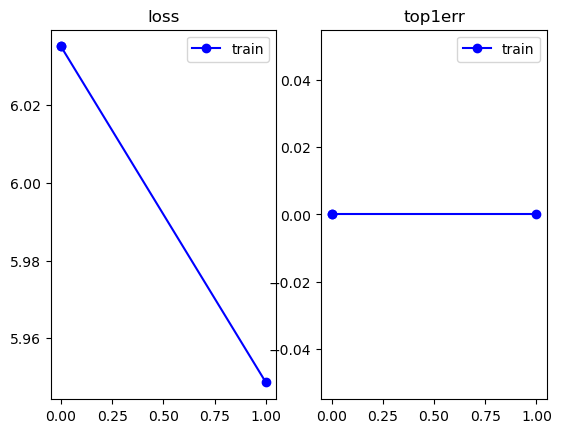

In [18]:
from timeit import default_timer as timer
from tqdm.auto import tqdm
from model.evaluation import train_step, test_step # use torchmetrics.utilities.data.select_topk
from model.utilis import print_train_time, accuracy_top_k
import matplotlib.pyplot as plt

y_loss = {}  # loss history
y_loss['train'] = []
y_loss['val'] = []
top5_rate = {}
top5_rate['train'] = []
top5_rate['val'] = []

x_epoch = []

fig = plt.figure()
ax0 = fig.add_subplot(121, title="loss")
ax1 = fig.add_subplot(122, title="top1err")

def draw_curve(current_epoch):
    x_epoch.append(current_epoch)
    ax0.plot(x_epoch, y_loss['train'], 'bo-', label='train')
    # ax0.plot(x_epoch, y_loss['val'], 'ro-', label='val')
    ax1.plot(x_epoch, top5_rate['train'], 'bo-', label='train')
    # ax1.plot(x_epoch, y_err['val'], 'ro-', label='val')
    if current_epoch == 0:
        ax0.legend()
        ax1.legend()
    #fig.savefig(os.path.join('./lossGraphs', 'train.jpg'))
running_loss = 0.0
running_corrects = 0.0

train_time_start_on_cpu = timer()

epochs = 2
for epoch in tqdm(range(epochs)):
    print(f'\n\tEpoch: {epoch}\n')

    (loss, top5) = train_step(model=model,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_top_k,
               device=device)
    
    # test_step(model=model,
    #            data_loader=test_dataloader,
    #            loss_fn=loss_fn,
    #            accuracy_fn=accuracy_top_k,
    #            device=device)
    
    y_loss["train"].append(loss)
    top5_rate["train"].append(top5)
    draw_curve(epoch)
# Print time taken
train_time_end_on_cpu = timer()
total_train_time_model = print_train_time(train_time_start_on_cpu, train_time_end_on_cpu, str(next(model.parameters()).device))

### Training loop - For testing CPU and GPU (do not change)

In [ ]:
from timeit import default_timer as timer
from tqdm.auto import tqdm
from model.evaluation import train_step_label, test_step_label # use torchmetrics.Accuracy()
from model.utilis import print_train_time, accuracy_fn

torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n')

    train_step_label(model=model,
               data_loader=MNIST_train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    
    test_step_label(model=model,
               data_loader=MNIST_test_dataloader,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device=device)

# Print time taken
train_time_end_on_cpu = timer()
total_train_time_model = print_train_time(train_time_start_on_cpu, train_time_end_on_cpu, str(next(model.parameters()).device))

### Calculate model results on test dataset

In [ ]:
model_results = test_step(model=model,
                           data_loader=test_dataloader,
                           loss_fn=loss_fn,
                           accuracy_fn=accuracy_top_k,
                           device=device)

model_results